In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay,classification_report, confusion_matrix
import ipywidgets as widgets
from teaching_tools.widgets import ConfusionMatrixWidget
import pickle


In [3]:
file_path = r"C:\Users\llubowa\Downloads\iot23_combined.csv"
range_drop = range(26)
def wrangle(path):
    df = pd.read_csv(path)

    #Binary encording the target feature(label)
    df["Malicious"]= (df["label"]=="Malicious").astype(int)

    # Identifying columns with low Cardinality
    drop_columns =[]
    for x in range_drop:
        p = df.columns[x]
        if df[p].nunique() ==2 and p !="Malicious":
            drop_columns.append(p)

    #Dropping columns with low Cardinality.
    df.drop(columns=drop_columns,inplace=True)
    
    return df

In [4]:
df = wrangle(file_path)
df.head()

,Unnamed: 0,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,Malicious
0,0,0.018988,84,204,0.0,2.0,140.0,2.0,260.0,0
1,1,0.029489,74,448,0.0,2.0,130.0,2.0,504.0,0
2,2,0.002984,66,110,0.0,2.0,122.0,2.0,166.0,0
3,3,0.033733,82,468,0.0,2.0,138.0,2.0,524.0,0
4,4,9.079338,337,2462,0.0,14.0,917.0,13.0,2986.0,1


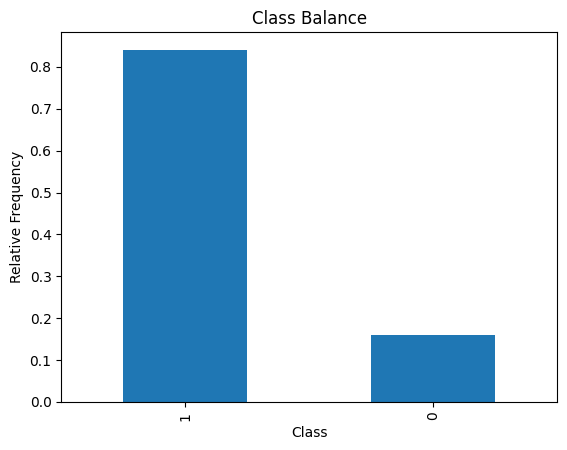

In [5]:
#Comparing relative frequency of Benign and Malicious connections
df["Malicious"].value_counts(normalize=True).plot(kind="bar",xlabel="Class", ylabel="Relative Frequency", title="Class Balance");


In [6]:
# Splitting Data into Feature and Target Vector
target = "Malicious"
X = df.drop(columns=target)
y = df[target]
print("X shape:",X.shape)
print("y shape:", y.shape)

X shape: (1246750, 9)
y shape: (1246750,)


In [7]:
# Splitting data (X and y) into training and test sets.  Test set is 20% of our total data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print("X_train shape:",X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (997400, 9)
y_train shape: (997400,)
X_test shape: (249350, 9)
y_test shape: (249350,)


In [ ]:
# Building The Model

In [8]:
# Baseline accuracy score
acc_baseline = y_train.value_counts(normalize=True).max()

In [9]:
print(round(acc_baseline,4))

0.8407


In [10]:
# Instantiating the Model
predictor = RandomForestClassifier(random_state=42)

In [11]:
# Parameter tunning
params = {
    "max_depth":range(18,21,5),
    "n_estimators":range(79,81,10)
}
params

{'max_depth': range(18, 21, 5), 'n_estimators': range(79, 81, 10)}

In [12]:
# Creating the Model using the GridSearchCV
model = GridSearchCV(
    predictor,
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
model

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(18, 21, 5),
                         'n_estimators': range(79, 81, 10)},
             verbose=1)

In [13]:
# Fitting the model to the over-sampled trainning data
model.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(18, 21, 5),
                         'n_estimators': range(79, 81, 10)},
             verbose=1)

In [14]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,182.205752,2.928026,2.164291,0.342122,18,79,"{'max_depth': 18, 'n_estimators': 79}",0.898165,0.897945,0.898476,0.898015,0.89801,0.898122,0.000191,1


In [15]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)
print(acc_train)
print(acc_test)

0.8997623821937036
0.8982955684780429


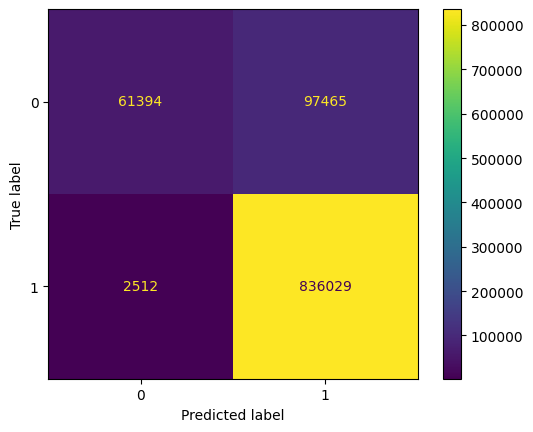

In [16]:
# Confusion Matrix on Training data
ConfusionMatrixDisplay.from_estimator(model,X_train,y_train)

In [17]:
# Classification report on training data
print(classification_report(y_train,model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      0.39      0.55    158859
           1       0.90      1.00      0.94    838541

    accuracy                           0.90    997400
   macro avg       0.93      0.69      0.75    997400
weighted avg       0.91      0.90      0.88    997400



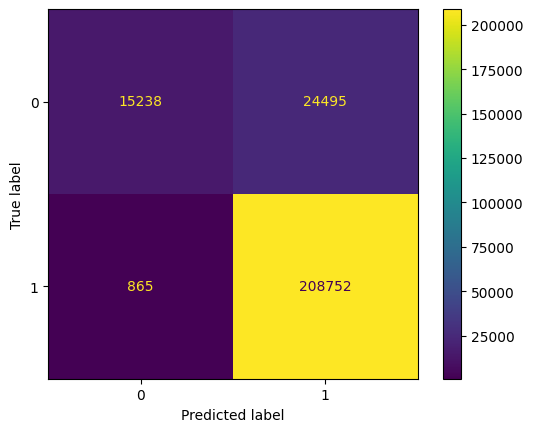

In [39]:
# Confusion Matrix on Test data
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

In [19]:
# Classification report on test data
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.38      0.55     39733
           1       0.89      1.00      0.94    209617

    accuracy                           0.90    249350
   macro avg       0.92      0.69      0.74    249350
weighted avg       0.90      0.90      0.88    249350



In [20]:
# Confusion Matrix Widget on test data
c_matrix = ConfusionMatrixWidget(model,X_test,y_test)
c_matrix.show()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

In [21]:
# COMMUNICATING MODEL RESULTS

In [22]:
# Getting feature names from trainning data
feature = X_train.columns
feature

Index(['Unnamed: 0', 'duration', 'orig_bytes', 'resp_bytes', 'missed_bytes',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'],
      dtype='object')

In [23]:
# Extracting feature importances from the model
importances = model.best_estimator_.feature_importances_
importances

array([8.21102034e-02, 4.15190665e-01, 8.34819198e-02, 6.38806344e-02,
       4.00728957e-05, 7.62204446e-02, 2.00914903e-01, 3.45094854e-02,
       4.36516715e-02])

In [28]:
feat_import = pd.Series(importances, index=feature).sort_values()
feat_import

missed_bytes     0.000040
resp_pkts        0.034509
resp_ip_bytes    0.043652
resp_bytes       0.063881
orig_pkts        0.076220
Unnamed: 0       0.082110
orig_bytes       0.083482
orig_ip_bytes    0.200915
duration         0.415191
dtype: float64

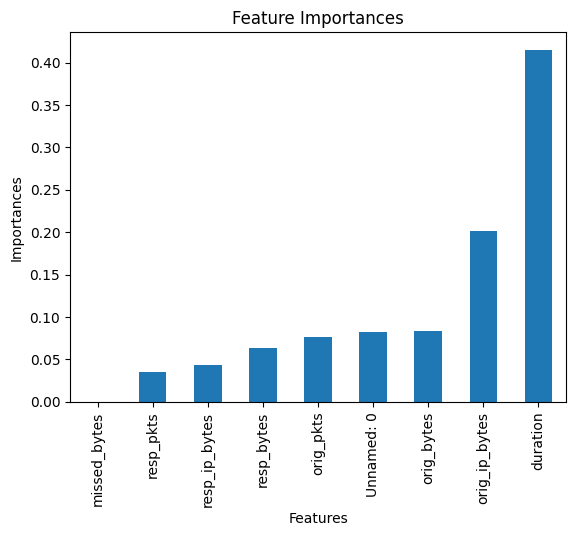

In [33]:
feat_import.plot(kind="bar")
plt.xlabel("Features")
plt.ylabel("Importances")
plt.title("Feature Importances");

In [35]:
# Saving The Model in pickel format
with open("IOT_Mal_Detector","wb") as f:
    pickle.dump(model,f)